# Image Model


In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import json
from umap import UMAP

### **Important**: If you want to use the precomputed local embeddings data (located at /embeddings), please set the variable "use_embeddings_data" to True. This will save time by skipping the recalculation of embeddings.

"use_embeddings_data" equals True will need 4 files:

- hybrid_embeddings located at /embeddings
- json_data_fact_checking located at /image_model
- json_data_fast_check_1_fixed located at /image_model
- json_data_fast_check_2_fixed located at /image_model


In [2]:
use_embeddings_data = True

In [3]:
if not use_embeddings_data: 
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def download_image(url):
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image

In [4]:
def check_images(data):
    pages_checked = data
    pages_urls = []
    images_downloaded = []
    relationships = []
    index = 0

    for page in data:
        images = []
        try: 
            for image in page["images"]:
                try:
                    download = download_image(image["image"]) 
                    images_downloaded.append(download)
                    images.append(image)
                except:
                    print("No fue posible descargar la imagen. Arreglando")
                    continue
            pages_checked[index]["images"] = images
            relationships.append(len(images))
            index += 1
            pages_urls += images
        except Exception as e:
            print("error al analizar la pagina")
            print(e)
            continue 
        
    print(f"Imagenes analizadas: {len(pages_urls)}")
    pages_checked = {"pages": pages_checked, "downloaded_images": images_downloaded, "relationships": relationships}
    
    return pages_checked

In [5]:
if not use_embeddings_data: 
    json_data = {}
    with open("./json_data_fast_check_1_fixed.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_fast_check_1_fixed = check_images(json_data["pages"])

In [6]:
if not use_embeddings_data: 
    json_data = {}
    with open("./json_data_fast_check_2_fixed.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_fast_check_2_fixed = check_images(json_data["pages"])

In [7]:
if not use_embeddings_data: 
    json_data = {}
    with open("./json_data_fact_checking.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_fact_checking = check_images(json_data["pages"])

In [8]:
if not use_embeddings_data: 
    with torch.no_grad():
        inputs = processor(images=json_data_fast_check_1_fixed["downloaded_images"], return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        image_embeddings = outputs
        torch.save(image_embeddings, '../embeddings/1st_image_embeddings.pt')

In [9]:
if not use_embeddings_data: 
    with torch.no_grad():
        inputs = processor(images=json_data_fast_check_2_fixed["downloaded_images"], return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        image_embeddings = outputs
        torch.save(image_embeddings, '../embeddings/2nd_image_embeddings.pt')

In [10]:
if not use_embeddings_data: 
    with torch.no_grad():
        inputs = processor(images=json_data_fact_checking["downloaded_images"], return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        image_embeddings = outputs
        torch.save(image_embeddings, '../embeddings/fact_checking_image_embeddings.pt')

In [11]:
if not use_embeddings_data: 
    json_data_fact_checking = {"pages": json_data_fact_checking["pages"]}
    json_data_fast_check_1_fixed = {"pages": json_data_fast_check_1_fixed["pages"]}
    json_data_fast_check_2_fixed = {"pages": json_data_fast_check_2_fixed["pages"]}

    with open(f"json_data_fact_checking.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fact_checking, file, ensure_ascii=False, indent=4)
    with open(f"json_data_fast_check_1_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fast_check_1_fixed, file, ensure_ascii=False, indent=4)
    with open(f"json_data_fast_check_2_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fast_check_2_fixed, file, ensure_ascii=False, indent=4)

else: 
    json_data_fact_checking = {}
    json_data_fast_check_1_fixed = {}
    json_data_fast_check_2_fixed = {}

    with open(f"../../data/json_data_fact_checking_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fact_checking = json.load(file)
    with open(f"../../data/json_data_fast_check_1_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fast_check_1_fixed = json.load(file)
    with open(f"../../data/json_data_fast_check_2_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fast_check_2_fixed = json.load(file)

In [12]:
#Estructura de datos para guardar las relaciones entre las imagenes y las noticias
relationships = []
image_relationships = []
for page in json_data_fast_check_1_fixed["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

for page in json_data_fast_check_2_fixed["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

for page in json_data_fact_checking["pages"]:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

#Crea una lista de cluster para luego visualizar que imagen pertenece a que noticia.
amount = 0
cluster_relationships = []
for index, relation in enumerate(relationships):
    amount += relation
    if relation == 0:
        continue
    for i in range(relation):
        cluster_relationships.append(index)

In [13]:
image_embeddings_1st = torch.load('1st_image_embeddings.pt')
image_embeddings_2nd = torch.load('2nd_image_embeddings.pt')
image_embeddings_fact_checking = torch.load('fact_checking_image_embeddings.pt')
text_embeddings_1st = torch.load('../text_model/1st_RoBERTa_text_embeddings.pt')
text_embeddings_2nd = torch.load('../text_model/2nd_RoBERTa_text_embeddings.pt')
text_embeddings_fact_checking = torch.load('../text_model/fact_checking_RoBERTa_text_embeddings.pt')

#Text
hybrid_text_embeddings = torch.cat((text_embeddings_1st, text_embeddings_2nd, text_embeddings_fact_checking), dim=0)
hybrid_text_embeddings = torch.cat(
    [hybrid_text_embeddings[i].unsqueeze(0).repeat(n, 1) for i, n in enumerate(relationships) if n != 0],
    dim=0
)

#Images
hybrid_image_embeddings = torch.cat((image_embeddings_1st, image_embeddings_2nd, image_embeddings_fact_checking), dim=0)

#Concatenación
print(hybrid_text_embeddings.shape)
print(hybrid_image_embeddings.shape)
hybrid_embeddings = torch.cat((hybrid_text_embeddings, hybrid_image_embeddings), dim=1)

#Forma Final
print(hybrid_embeddings.shape)
torch.save(hybrid_embeddings, 'hybrid_embeddings.pt')
hybrid_embeddings = torch.load('hybrid_embeddings.pt')

torch.Size([340, 1024])
torch.Size([340, 512])
torch.Size([340, 1536])


C:\Users\usuario\AppData\Local\Temp\ipykernel_17360\1537622854.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings_1st = torch.load('1st_image_embeddings.pt

# **Important**

# If you want to use the precomputed local embeddings data (located at /embeddings), please set the variable "use_embeddings_data" to **True** at the start of this code. This will save time by avoiding the recalculation of embeddings.

# If you want to recalculate the embeddings, set the variable "use_embedding_data" to **False** at the start of this code.


c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


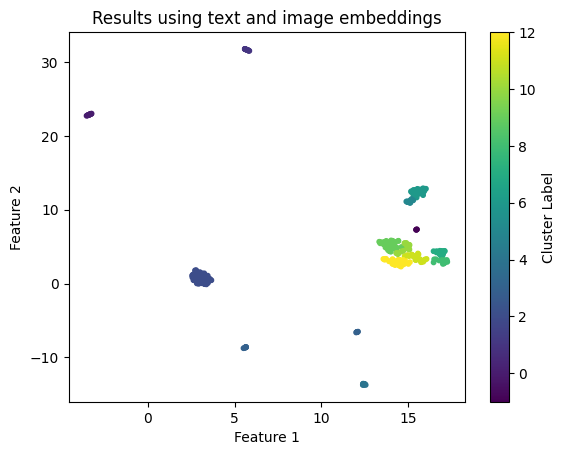

Distancia promedio: 11.940122604370117
Distancia mínima: 5.981028516544029e-05
Distancia máxima: 46.0141487121582
Silhouette Score: 0.6745898127555847


In [14]:
umap_model= UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(hybrid_embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(embeddings_2d)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using text and image embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')
average_distance = np.mean(distances)
min_distance = np.min(distances[distances > 0])
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

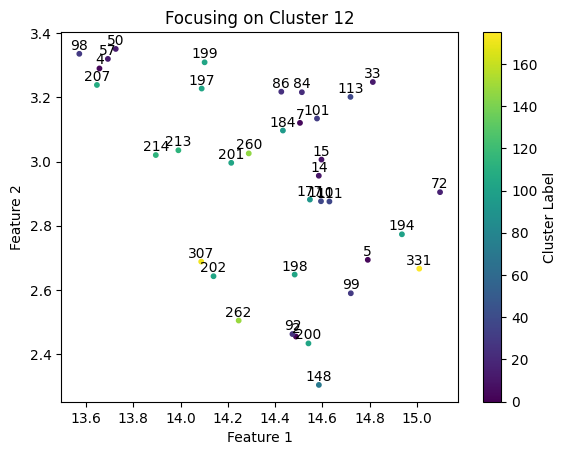

[2]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/busk.png
[2]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/
[2]   indice de página: 0

[4]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/09/Captura-de-Pantalla-2022-09-09-a-las-10.56.24-1024x570.png
[4]   Pagina: https://www.fastcheck.cl/2022/09/09/imagen-a-espaldas-de-la-ciudadania-cambiaron-el-articulo-142-de-la-constitucion-enganoso/
[4]   indice de página: 3

[5]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/09/Captura-de-Pantalla-2022-09-09-a-las-11.33.54-1024x179.png
[5]   Pagina: https://www.fastcheck.cl/2022/09/09/imagen-a-espaldas-de-la-ciudadania-cambiaron-el-articulo-142-de-la-constitucion-enganoso/
[5]   indice de página: 3

[7]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/08/articulo-67.jpg
[7]   Pagina: https://www.fastcheck.cl/2022/08/11/articulo-67-4-res

In [15]:
hdbscan_cluster_to_print = 12
facts_selected = []
facts_labels = []
text_cluster = []

for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == hdbscan_cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        text_cluster.append(cluster_relationships[index])


plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], c=text_cluster, cmap='viridis', s=10)
for x, y, label in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')
plt.title(f'Focusing on Cluster {hdbscan_cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]
for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print(f"[{index}]   indice de página: {cluster_relationships[index]}")
    print("")


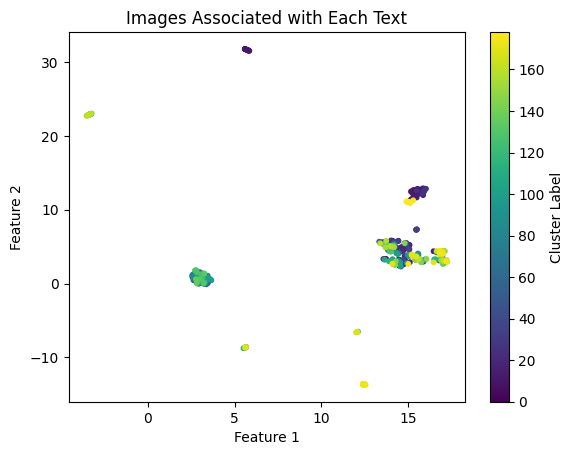

In [16]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_relationships, cmap='viridis', s=10)
plt.title('Images Associated with Each Text')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

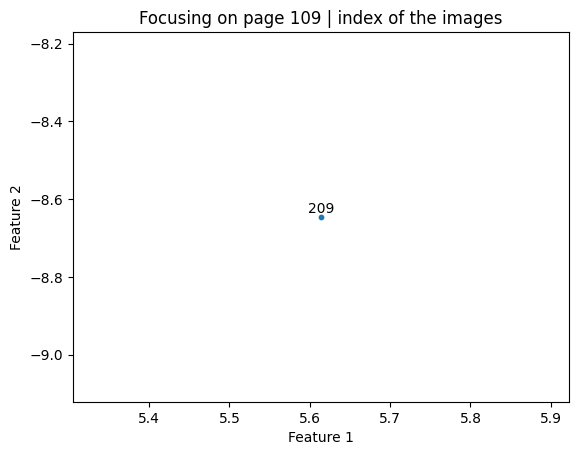

[209]   Imagen: {'image': 'https://i2.wp.com/factchecking.cl/wp-content/uploads/2020/10/IMG-20201021-WA0000.jpg?resize=810%2C305&ssl=1', 'text': 'ESPECIAL PLEBISCITO 2020\n\n5 2-4 De $\nmm >= a >\n\nví\n', 'error': False}
[209]   Pagina: https://factchecking.cl/user-review/un-eventual-cambio-constitucional-de-chile-no-se-puede-comparar-con-islandia/



In [17]:
page_to_print = 109

json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]

facts_selected = []
facts_labels = []

for index, fact in enumerate(embeddings_2d):
    if cluster_relationships[index] == page_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

labels = []
labels_index = []
labels_relation = []

for index, image in enumerate(image_relationships):
    if index in facts_labels:
        labels_relation.append(image["page"]["veracity"])
        if image["page"]["veracity"] not in labels:
            labels.append(image["page"]["veracity"])
        labels_index.append(labels.index(image["page"]["veracity"]))

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)

for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

plt.title(f'Focusing on page {page_to_print} | index of the images')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print("")

## Show Cluster by image index


12


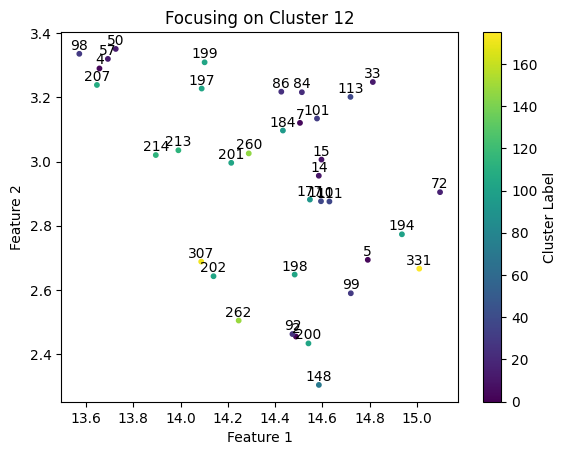

[2]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/05/busk.png
[2]   Pagina: https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/
[2]   indice de página: 0

[4]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/09/Captura-de-Pantalla-2022-09-09-a-las-10.56.24-1024x570.png
[4]   Pagina: https://www.fastcheck.cl/2022/09/09/imagen-a-espaldas-de-la-ciudadania-cambiaron-el-articulo-142-de-la-constitucion-enganoso/
[4]   indice de página: 3

[5]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/09/Captura-de-Pantalla-2022-09-09-a-las-11.33.54-1024x179.png
[5]   Pagina: https://www.fastcheck.cl/2022/09/09/imagen-a-espaldas-de-la-ciudadania-cambiaron-el-articulo-142-de-la-constitucion-enganoso/
[5]   indice de página: 3

[7]   Imagen: https://www.fastcheck.cl/wp-content/uploads/2022/08/articulo-67.jpg
[7]   Pagina: https://www.fastcheck.cl/2022/08/11/articulo-67-4-res

In [18]:
image_index = 99
hdbscan_cluster_to_print = cluster_labels[image_index]
print(hdbscan_cluster_to_print)
facts_selected = []
facts_labels = []
text_cluster = []

for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == hdbscan_cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        text_cluster.append(cluster_relationships[index])

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], c=text_cluster, cmap='viridis', s=10)
for x, y, label in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')
plt.title(f'Focusing on Cluster {hdbscan_cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]
for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print(f"[{index}]   indice de página: {cluster_relationships[index]}")
    print("")


## Show cluster by fact index


clusters de HDBSCAN asociados a la noticia: 
[8]
[11]


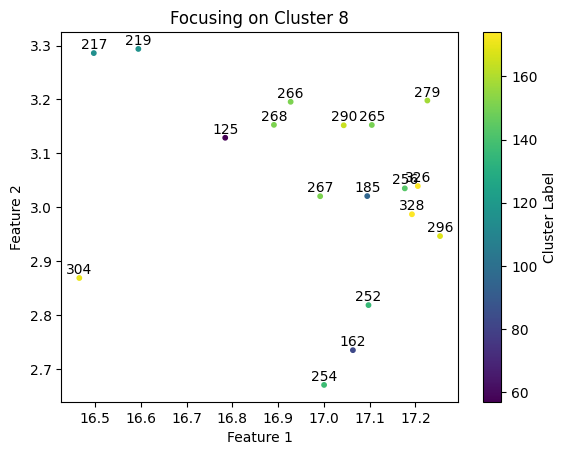

[125]   Imagen: https://i1.wp.com/factchecking.cl/wp-content/uploads/2022/09/sequia.png?resize=512%2C272&ssl=1
[125]   Pagina: https://factchecking.cl/user-review/la-propuesta-de-nueva-constitucion-asegura-la-seguridad-para-sembrar-y-prioriza-el-uso-y-disponibilidad-del-agua-para-las-personas-y-ecosistemas/
[125]   indice de página: 57

[162]   Imagen: https://i1.wp.com/factchecking.cl/wp-content/uploads/2022/08/Voto-indicación-nº48.jpeg?resize=810%2C455&ssl=1
[162]   Pagina: https://factchecking.cl/user-review/la-propuesta-de-la-creacion-de-una-defensoria-de-las-victimas-fue-rechazada-por-la-convencion-constitucional/
[162]   indice de página: 83

[185]   Imagen: https://i2.wp.com/factchecking.cl/wp-content/uploads/2022/08/Tabla-imagen-2.png?resize=425%2C322&ssl=1
[185]   Pagina: https://factchecking.cl/user-review/el-derecho-a-la-vivienda-esta-consagrado-en-la-propuesta-de-nueva-constitucion-pero-esto-no-significa-que-las-casas-seran-del-estado/
[185]   indice de página: 95

[217]  

In [23]:
# Una misma noticia, como tiene varias imagenes, es posible entonces que la noticia como tal esté en más de un cluster.
fact_index = 170

if fact_index not in cluster_relationships:
    print("No se encontró la noticia en los clusters")
    exit()

hdbscan_clusters_to_print = []
for index, relation in enumerate(cluster_relationships):
    if relation == fact_index:
        hdbscan_clusters_to_print.append(cluster_labels[index])
hdbscan_clusters_to_print = list(set(hdbscan_clusters_to_print))

if len(hdbscan_clusters_to_print) == 0:
    print("No se encontraron clusters asociados a la noticia")
    exit()

print("clusters de HDBSCAN asociados a la noticia: ")
for cluster in hdbscan_clusters_to_print:
    print(f"[{cluster}]")


facts_selected = []
facts_labels = []
text_cluster = []
for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == hdbscan_clusters_to_print[0]:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        text_cluster.append(cluster_relationships[index])


plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], c=text_cluster, cmap='viridis', s=10)
for x, y, label in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')
plt.title(f'Focusing on Cluster {hdbscan_clusters_to_print[0]}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()


json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]
for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print(f"[{index}]   indice de página: {cluster_relationships[index]}")
    print("")